In [1]:
import numba
import numpy as np
from PIL import Image

In [2]:
import  matplotlib.pyplot as plt 
import time 

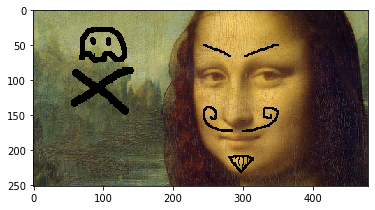

In [4]:
PATH = "./Lab3_data/"
test_image = np.array(Image.open(PATH + 'mona-lisa-damaged.png'))
plt.imshow(test_image)

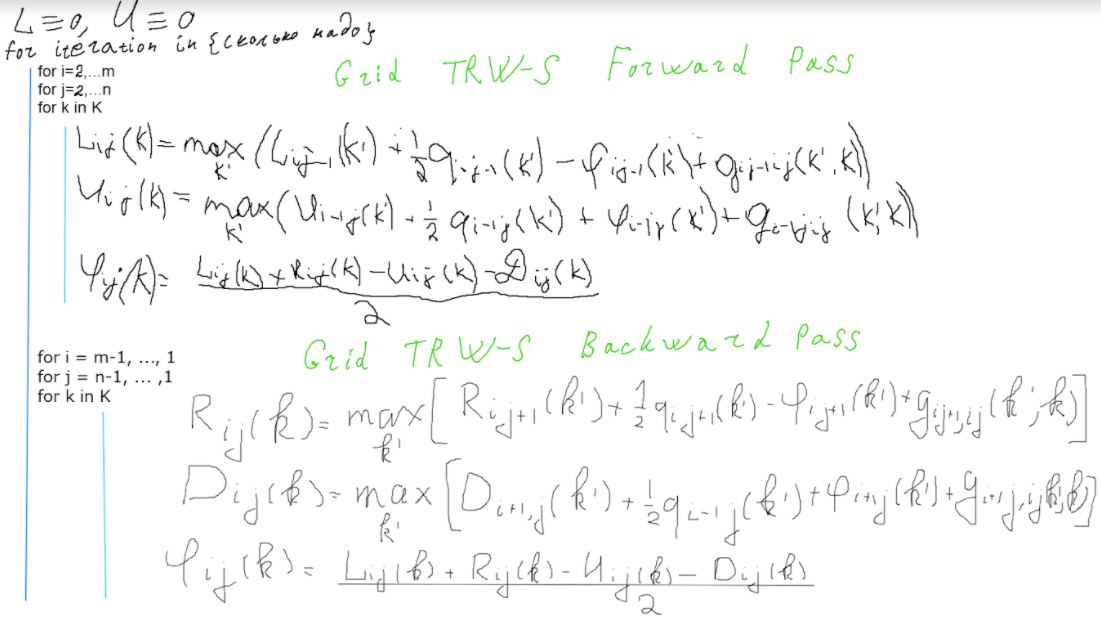

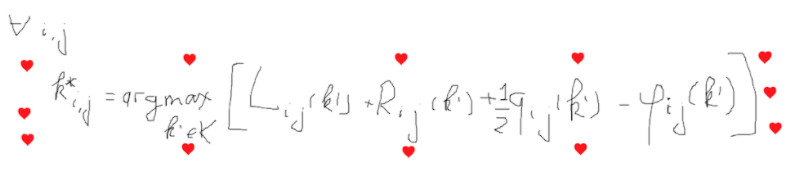

In [116]:
@numba.jit(nopython = True)                
def leftPath(i,j,phi,g,q,k,n_C,L):
    '''
    q - > array[w,h,n_C]
    i,j - > int,int
    L -> array[w,h,n_C]
    n_C -> len(C)
    phi - > array[w,h,n_C]
    g -> array[n_C,n_C]
    return -> left best k_ for obj t(i,j) 
    '''
    values = np.zeros((n_C,), dtype = np.float32)
    for k_ in range(n_C):
        values[k_] = L[i, j - 1, k_] + 0.5 * q[i, j - 1, k_] - phi[i, j - 1, k_] + g[k_, k]
    return values.max()

@numba.jit(nopython = True)
def upperPath(i,j,phi,g,q,k,n_C,U):
    '''
    q - > array[w,h,n_C]
    i,j - > int,int
    U -> array[w,h,n_C]
    n_C -> len(C)
    phi - > array[w,h,n_C]
    g -> array[n_C,n_C]
    return -> upper best k_ for obj t(i,j) 
    '''
    values = np.zeros((n_C,), dtype = np.float32)
    for k_ in range(n_C):
        values[k_] = U[i - 1, j, k_] + 0.5 * q[i - 1, j, k_] - phi[i - 1, j, k_] + g[k_, k]
    return values.max()

@numba.jit(nopython = True)
def rightPath(i,j,phi,g,q,k,n_C,R):
    '''
    q - > array[w,h,n_C]
    i,j - > int,int
    R -> array[w,h,n_C]
    n_C -> len(C)
    phi - > array[w,h,n_C]
    g -> array[n_C,n_C]
    return -> right best k_ for obj t(i,j) 
    '''
    values = np.zeros((n_C,), dtype = np.float32)
    for k_ in range(n_C):
        values[k_] = R[i, j + 1, k_] + 0.5 * q[i, j + 1, k_] + phi[i, j + 1, k_] + g[k_, k]
    return values.max()

@numba.jit(nopython = True)
def downPath(i,j,phi,g,q,k,n_C,D):
    '''
    q - > array[w,h,n_C]
    i,j - > int,int
    D -> array[w,h,n_C]
    n_C -> len(C)
    phi - > array[w,h,n_C]
    g -> array[n_C,n_C]
    return -> down best k_ for obj t(i,j) 
    '''
    values = np.zeros((n_C,), dtype = np.float32)
    for k_ in range(n_C):
        values[k_] = D[i + 1, j, k_] + 0.5 * q[i + 1, j, k_] + phi[i + 1, j, k_] + g[k_, k]
    return values.max()

@numba.jit(nopython = True)               
def restore_k(i, j, C,n_C,L,R,q,phi):
    '''
    Returns besk k for object after TRW-S
    return -> argmax(k*)
    '''
    values = np.zeros(n_C, dtype = np.float32)
    for k_ in range(n_C):
        values[k_] = L[i, j, k_] + R[i, j, k_] + q[i, j, k_] - phi[i, j, k_]
    return C[values.argmax()]

@numba.jit(nopython = True)
def getQ(image,i, j, k):
    '''
    i,j -> t object(pixel)
    k -> label {k is in C}
    return -> -|xt - kt| or 0 otherwise
    '''
    if image[i, j] != 0:
        return -abs(image[i, j] - C[k])
    else:
        return 0
    
@numba.jit(nopython = True)    
def Q(image,w,h,n_C):
    '''
    n_C -> len(C)
    output -> array[w,h,n_C]
    '''
    q = np.zeros((h,w , n_C), dtype=np.float32)
    for i in range(h):
        for j in range(w):
            for k in range(n_C):
                q[i, j, k]= getQ(image,i, j, k)
    return q

@numba.jit(nopython = True)
def output(w,h,C,L,R,q,phi):
    '''
    return -> output image [h,w]
    '''
    new_img = np.zeros((h, w), dtype=np.uint8)
    for i in range(0, h):
        for j in range(1, w-1):
            new_img[i, j] = restore_k(i, j,C,len(C),L,R,q,phi)
    return new_img

In [156]:
@numba.jit(nopython = True)  
def TRWS(image,epoch,C):
    '''
    Whole TRW-S alg 
    '''
    n_C = len(C)
    h = image.shape[0]
    w = image.shape[1]
    q = Q(image,w,h,n_C)
    L = np.zeros((h, w, n_C), dtype=np.float64)
    R = np.zeros((h, w, n_C), dtype=np.float64)
    U = np.zeros((h, w, n_C), dtype=np.float64)
    D = np.zeros((h, w, n_C), dtype=np.float64)
    
    phi = np.zeros((h, w, n_C))
    g = np.zeros((n_C, n_C), dtype=np.float32)
    
    for i in range(n_C):
        for j in range(n_C):
            g[i, j] = -abs(C[i] - C[j])
            
    for i in (range(h - 2, 0,-1)):
        for j in (range(w -2,0 ,-1)):
            for k in range(n_C):
                R[i, j, k] = rightPath(i,j,phi,g,q,k,n_C,R)
                D[i, j, k] = downPath(i, j, phi,g,q,k,n_C,D)
    
    for ep in range(epoch):
        for i in range(h):
            for j in range(w):
                for k in range(n_C):
                    L[i,j,k] = leftPath(i,j,phi,g,q,k,n_C,L)
                    U[i,j,k] = upperPath(i,j,phi,g,q,k,n_C,U)
                    phi[i,j,k] = (L[i,j,k] + U[i,j,k] - R[i,j,k] - D[i,j,k])/2
                    
        for i in (range(h -2, 0,-1)):
            for j in (range(w -2,0 ,-1)):
                for k in range(n_C):
                    R[i,j,k] = rightPath(i,j,phi,g,q,k,n_C,R)
                    D[i,j,k] = downPath(i,j,phi,g,q,k,n_C,D)
                    phi[i,j,k] = (L[i,j,k] + U[i,j,k] - R[i,j,k] - D[i,j,k])/2
    return output(w,h,C,L,R,q,phi)
                

In [157]:
C = np.array((np.random.randint(0,255,16)),dtype=np.float32)
C.sort()
C

array([ 18.,  27.,  32.,  48.,  56.,  65.,  70.,  99., 106., 152., 168.,
       185., 219., 241., 241., 251.], dtype=float32)

In [158]:
image = np.array(test_image, dtype=np.float32)
st = time.time() 
epoch = 30
output0 = TRWS(image[:,:,0],epoch,C)
output1 = TRWS(image[:,:,1],epoch,C)
output2 = TRWS(image[:,:,2],epoch,C)
temp = time.time() - st
print("Epoch: {0} | Total Time: {1}s".format(epoch,round(temp,2)))

Epoch: 30 | Total Time: 100.62s


In [153]:
img_ = np.zeros((h,w,3))

img_[:,:,0] = output0
img_[:,:,1] = output1
img_[:,:,2] = output2

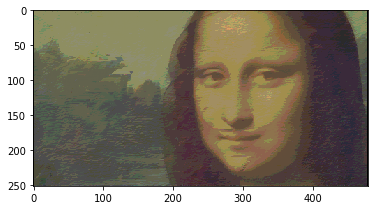

In [154]:
plt.imshow(img_ / 255)